In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))


In [2]:
import pandas as pd

from src.config import US_BANK_TICKERS
from src.data import DataConfig, download_prices
from src.selection import SelectionConfig, select_pairs


In [3]:
cfg_data = DataConfig(
    start="2015-01-01",
    cache_name="us_banks_adjclose.parquet"
)

prices = download_prices(
    US_BANK_TICKERS,
    cfg_data,
    force_refresh=False
)


In [4]:
train = prices.loc["2017-01-01":"2019-12-31"]

cfg_sel = SelectionConfig(
    corr_threshold=0.7,
    adf_pvalue_threshold=0.05,
    half_life_min=2,
    half_life_max=30,
    top_n=10
)

selected = select_pairs(train, cfg_sel)
selected


,a,b,corr,alpha,beta,adf_p,half_life,resid_std,n_obs,hl_distance
0,BAC,TFC,0.801109,-1.582700,1.324331,0.001085,19.490392,0.040752,754,3.490392
1,JPM,TFC,0.803600,-0.618569,1.417704,0.011955,28.848417,0.050865,754,12.848417


In [5]:
train_2 = prices.loc["2021-01-01":"2023-12-31"]
selected_2 = select_pairs(train_2, cfg_sel)

selected_2


,a,b,corr,alpha,beta,adf_p,half_life,resid_std,n_obs,hl_distance
0,BAC,PNC,0.811422,-1.184531,0.941800,0.001680,18.016914,0.040290,753,2.016914
1,PNC,USB,0.798689,1.875371,0.835960,0.003984,18.698858,0.042880,753,2.698858
2,BAC,USB,0.750643,0.600017,0.782325,0.011713,27.719756,0.059242,753,11.719756


In [6]:
from src.signals import SignalConfig, generate_signals

# Suppose you pick the first selected pair:
row = selected_2.iloc[0]
pair = (row["a"], row["b"])
alpha, beta = float(row["alpha"]), float(row["beta"])

# Define a test period (IMPORTANT: different from training)
test_prices = prices.loc["2024-01-01":"2025-12-31", list(pair)]

sig_cfg = SignalConfig(z_lookback=60, entry_z=2.0, exit_z=0.5)
signals = generate_signals(test_prices, pair, alpha, beta, sig_cfg)
signals.tail()


,spread_BAC_PNC,zscore,position
Date,,,
2025-12-24,0.162952,-0.822513,0
2025-12-26,0.159722,-0.925030,0
2025-12-29,0.153508,-1.110862,0
2025-12-30,0.156294,-1.067374,0
2025-12-31,0.161671,-0.955046,0


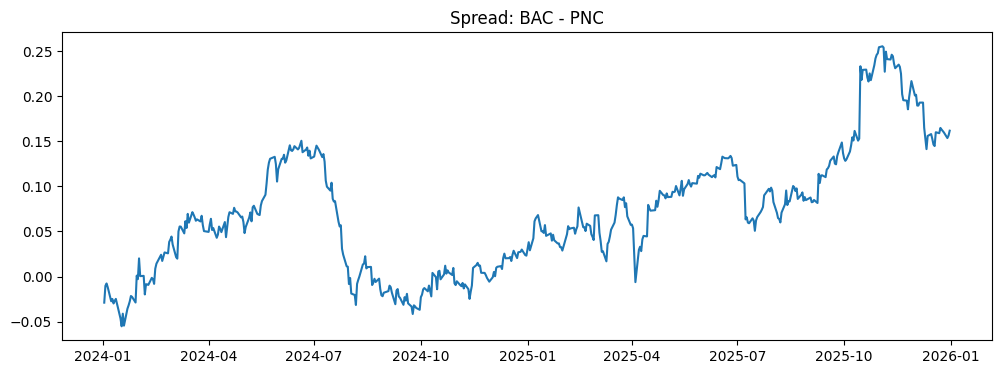

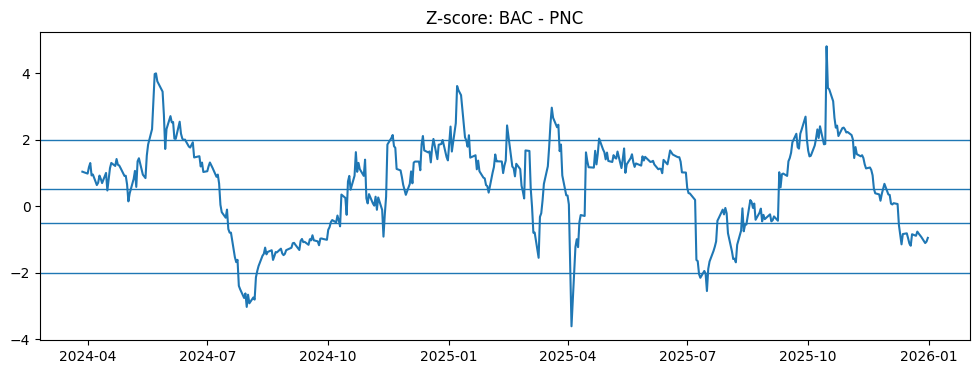

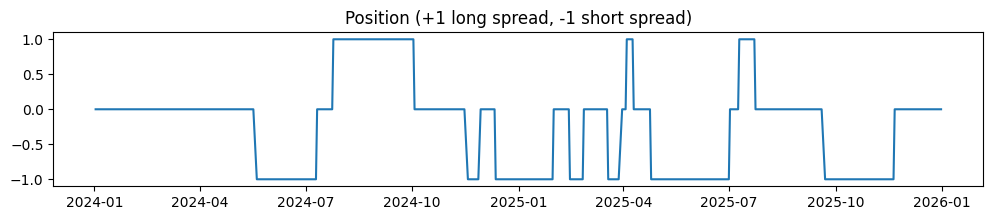

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(signals["spread_" + pair[0] + "_" + pair[1]])
plt.title(f"Spread: {pair[0]} - {pair[1]}")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(signals["zscore"])
plt.axhline(2.0, lw=1)
plt.axhline(-2.0, lw=1)
plt.axhline(0.5, lw=1)
plt.axhline(-0.5, lw=1)
plt.title(f"Z-score: {pair[0]} - {pair[1]}")
plt.show()

plt.figure(figsize=(12,2))
plt.plot(signals["position"])
plt.title("Position (+1 long spread, -1 short spread)")
plt.show()


In [8]:
from src.backtest import BacktestConfig, backtest_pair, performance_summary

row = selected_2.iloc[0]
pair = (row["a"], row["b"])
beta = float(row["beta"])

test_prices = prices.loc["2024-01-01":"2025-12-31", list(pair)]

bt_cfg = BacktestConfig(cost_bps=10.0)
bt = backtest_pair(test_prices, signals, pair, beta, bt_cfg)

bt.tail()
performance_summary(bt["net_ret"], bt_cfg)


{'ann_return': -0.006907781117441392,
 'ann_vol': 0.05622089510657757,
 'sharpe': -0.1232932157307096,
 'max_drawdown': -0.06616811892054919,
 'avg_daily_ret': -2.7506567257733588e-05,
 'vol_daily': 0.003541583498510772,
 'hit_rate': 0.24550898203592814,
 'n_days': 501}

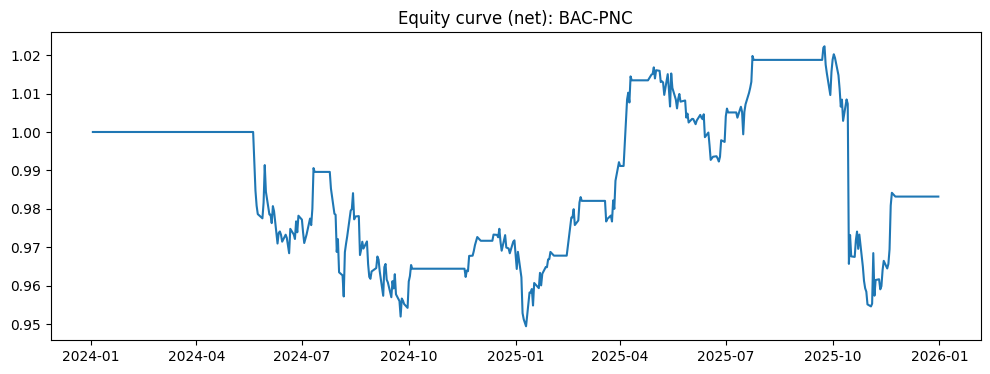

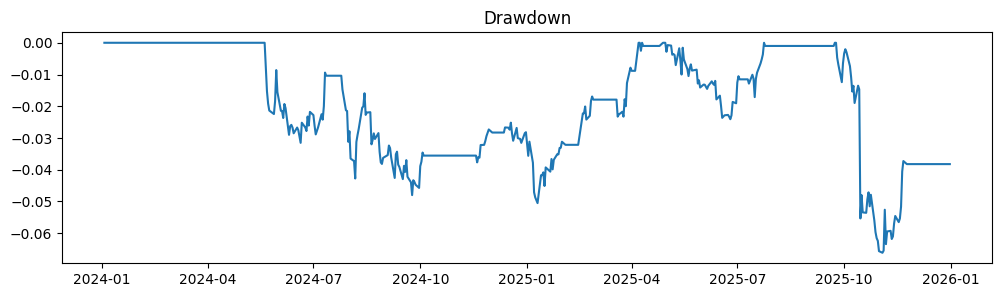

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(bt["equity"])
plt.title(f"Equity curve (net): {pair[0]}-{pair[1]}")
plt.show()

# drawdown
equity = bt["equity"]
dd = equity / equity.cummax() - 1.0
plt.figure(figsize=(12,3))
plt.plot(dd)
plt.title("Drawdown")
plt.show()


In [10]:
import pandas as pd
import numpy as np

from src.selection import SelectionConfig, select_pairs
from src.signals import SignalConfig, generate_signals
from src.backtest import BacktestConfig, backtest_pair, performance_summary


In [11]:
def run_portfolio_for_window(
    prices: pd.DataFrame,
    train_start: str,
    train_end: str,
    test_start: str,
    test_end: str,
    sel_cfg: SelectionConfig,
    sig_cfg: SignalConfig,
    bt_cfg: BacktestConfig,
):
    # --- Train selection ---
    train_prices = prices.loc[train_start:train_end]
    selected = select_pairs(train_prices, sel_cfg)

    if selected.empty:
        return None, None, None

    # --- For each selected pair: generate signals on TEST window + backtest ---
    pair_results = {}
    net_returns_list = []

    for _, row in selected.iterrows():
        a, b = row["a"], row["b"]
        pair = (a, b)

        alpha, beta = float(row["alpha"]), float(row["beta"])

        test_prices = prices.loc[test_start:test_end, [a, b]].dropna()
        if len(test_prices) < 100:
            continue

        signals = generate_signals(test_prices, pair, alpha, beta, sig_cfg)
        bt = backtest_pair(test_prices, signals, pair, beta, bt_cfg)

        pair_results[pair] = {
            "bt": bt,
            "summary": performance_summary(bt["net_ret"], bt_cfg),
            "params": {"alpha": alpha, "beta": beta}
        }

        net_returns_list.append(bt["net_ret"].rename(f"{a}_{b}"))

    if not net_returns_list:
        return selected, None, None

    # --- Combine into equal-weight portfolio ---
    port_rets = pd.concat(net_returns_list, axis=1)
    # equal-weight across available pairs each day
    port_net_ret = port_rets.mean(axis=1, skipna=True).rename("port_net_ret")
    port_equity = (1.0 + port_net_ret).cumprod().rename("port_equity")

    portfolio = pd.concat([port_net_ret, port_equity], axis=1)

    return selected, pair_results, portfolio


In [12]:
sel_cfg = SelectionConfig(corr_threshold=0.7, adf_pvalue_threshold=0.05, half_life_min=2, half_life_max=30, top_n=3)
sig_cfg = SignalConfig(z_lookback=60, entry_z=2.0, exit_z=0.5)
bt_cfg  = BacktestConfig(cost_bps=10.0)

selected, pair_results, portfolio = run_portfolio_for_window(
    prices,
    train_start="2021-01-01", train_end="2023-12-31",
    test_start="2024-01-01",  test_end="2025-12-31",
    sel_cfg=sel_cfg, sig_cfg=sig_cfg, bt_cfg=bt_cfg
)

selected, portfolio.tail()


(     a    b      corr     alpha      beta     adf_p  half_life  resid_std  \
 0  BAC  PNC  0.811422 -1.184531  0.941800  0.001680  18.016914   0.040290   
 1  PNC  USB  0.798689  1.875371  0.835960  0.003984  18.698858   0.042880   
 2  BAC  USB  0.750643  0.600017  0.782325  0.011713  27.719756   0.059242   
 
    n_obs  hl_distance  
 0    753     2.016914  
 1    753     2.698858  
 2    753    11.719756  ,
             port_net_ret  port_equity
 Date                                 
 2025-12-24           0.0     0.993476
 2025-12-26           0.0     0.993476
 2025-12-29           0.0     0.993476
 2025-12-30           0.0     0.993476
 2025-12-31           0.0     0.993476)

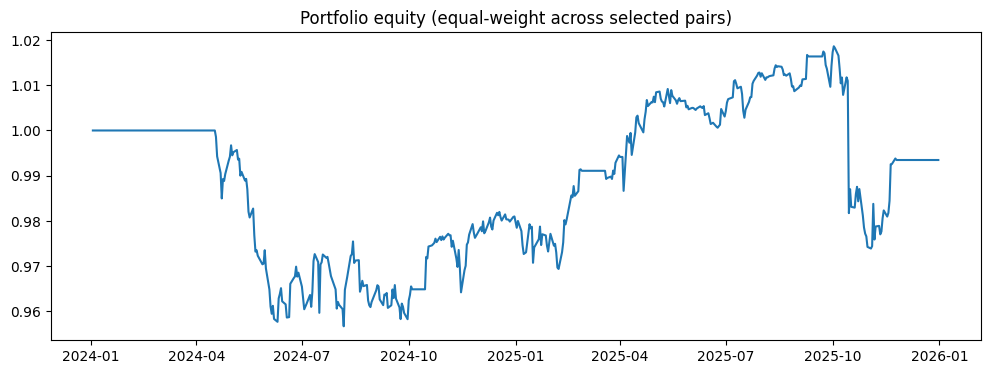

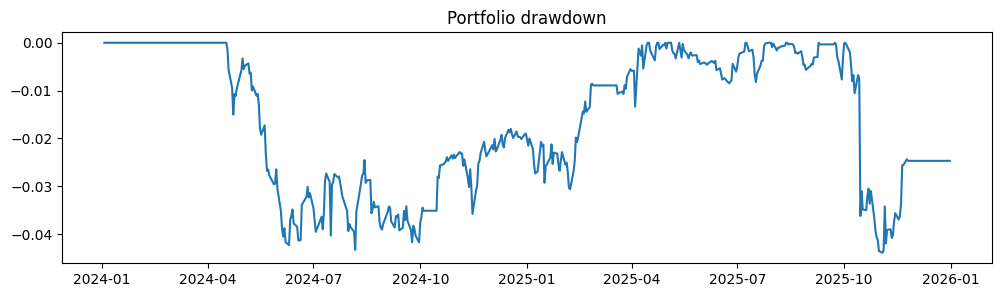

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(portfolio["port_equity"])
plt.title("Portfolio equity (equal-weight across selected pairs)")
plt.show()

dd = portfolio["port_equity"] / portfolio["port_equity"].cummax() - 1.0
plt.figure(figsize=(12,3))
plt.plot(dd)
plt.title("Portfolio drawdown")
plt.show()


In [14]:
pair_summaries = []
for pair, res in pair_results.items():
    s = res["summary"].copy()
    s["pair"] = f"{pair[0]}-{pair[1]}"
    pair_summaries.append(s)

pd.DataFrame(pair_summaries).set_index("pair").sort_values("sharpe", ascending=False)


,ann_return,ann_vol,sharpe,max_drawdown,avg_daily_ret,vol_daily,hit_rate,n_days
pair,,,,,,,,
PNC-USB,0.014099,0.046215,0.302944,-0.043640,0.000056,0.002911,0.259481,501
BAC-PNC,-0.006908,0.056221,-0.123293,-0.066168,-0.000028,0.003542,0.245509,501
BAC-USB,-0.014127,0.067987,-0.209261,-0.084859,-0.000056,0.004283,0.231537,501


In [15]:
from src.backtest import performance_summary
performance_summary(portfolio["port_net_ret"], bt_cfg)


{'ann_return': -0.002383252427724858,
 'ann_vol': 0.04252647253722967,
 'sharpe': -0.05610824164841226,
 'max_drawdown': -0.04388065794714113,
 'avg_daily_ret': -9.468593641164483e-06,
 'vol_daily': 0.002678915963579231,
 'hit_rate': 0.3872255489021956,
 'n_days': 501}

In [17]:
from src.utils import generate_walkforward_splits, WalkForwardConfig

wf_cfg = WalkForwardConfig(
    train_years=3,
    test_months=12,
    step_months=12
)

splits = list(generate_walkforward_splits(prices.index, wf_cfg))
splits



[(Timestamp('2015-01-02 00:00:00'),
  Timestamp('2017-12-29 00:00:00'),
  Timestamp('2018-01-02 00:00:00'),
  Timestamp('2018-12-31 00:00:00')),
 (Timestamp('2015-01-02 00:00:00'),
  Timestamp('2018-12-31 00:00:00'),
  Timestamp('2019-01-02 00:00:00'),
  Timestamp('2019-12-31 00:00:00')),
 (Timestamp('2015-01-02 00:00:00'),
  Timestamp('2019-12-31 00:00:00'),
  Timestamp('2020-01-02 00:00:00'),
  Timestamp('2020-12-31 00:00:00')),
 (Timestamp('2015-01-02 00:00:00'),
  Timestamp('2020-12-31 00:00:00'),
  Timestamp('2021-01-04 00:00:00'),
  Timestamp('2021-12-31 00:00:00')),
 (Timestamp('2015-01-02 00:00:00'),
  Timestamp('2021-12-31 00:00:00'),
  Timestamp('2022-01-03 00:00:00'),
  Timestamp('2022-12-30 00:00:00')),
 (Timestamp('2015-01-02 00:00:00'),
  Timestamp('2022-12-30 00:00:00'),
  Timestamp('2023-01-03 00:00:00'),
  Timestamp('2023-12-29 00:00:00')),
 (Timestamp('2015-01-02 00:00:00'),
  Timestamp('2023-12-29 00:00:00'),
  Timestamp('2024-01-02 00:00:00'),
  Timestamp('2024-12-3

In [18]:
all_port_rets = []

for tr_start, tr_end, te_start, te_end in splits:
    selected, pair_results, portfolio = run_portfolio_for_window(
        prices,
        tr_start, tr_end,
        te_start, te_end,
        sel_cfg, sig_cfg, bt_cfg
    )

    if portfolio is None:
        continue

    all_port_rets.append(portfolio["port_net_ret"])


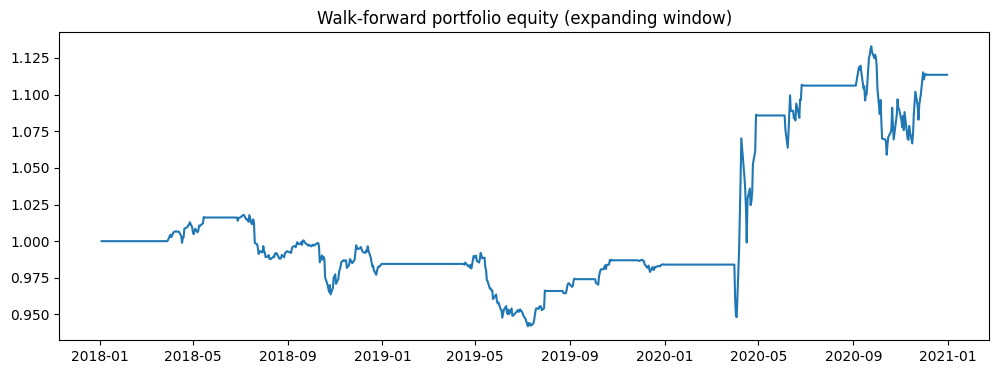

In [19]:
wf_port_ret = pd.concat(all_port_rets).sort_index()
wf_equity = (1 + wf_port_ret).cumprod()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(wf_equity)
plt.title("Walk-forward portfolio equity (expanding window)")
plt.show()


In [22]:
wf_port_ret.index.is_monotonic_increasing
wf_port_ret.index.duplicated().any()


np.False_

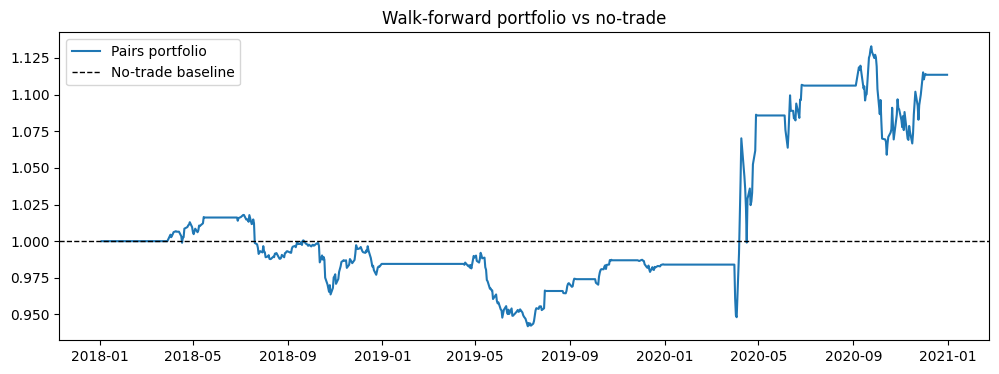

In [23]:
plt.figure(figsize=(12,4))
plt.plot(wf_equity, label="Pairs portfolio")
plt.axhline(1.0, color="black", lw=1, linestyle="--", label="No-trade baseline")
plt.legend()
plt.title("Walk-forward portfolio vs no-trade")
plt.show()
